In [19]:
import pandas as pd
import numpy as np
import json
import statistics
import warnings
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, tree, ensemble
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [5]:
with open('dtype_dict_EDA.json', 'r') as file:
    dtype_dict = json.load(file)


parse_date = [key for key, value in dtype_dict.items() if value == 'datetime64[ns]']
other_dtypes = {key: value for key, value in  dtype_dict.items() if value != 'datetime64[ns]' }

for key in other_dtypes:
    if other_dtypes[key] == 'category':
        other_dtypes[key] = 'category'
    else:
        other_dtypes[key] = pd.api.types.pandas_dtype(other_dtypes[key])


df = pd.read_csv("Data/final_data.csv", dtype = other_dtypes, parse_dates= parse_date)


In [93]:
df.columns

Index(['House_Name', 'Location', 'Municipality', 'House_type', 'Release_form',
       'Rooms', 'Floor', 'Total_no_Floors', 'Lift', 'Balcony', 'Living_area',
       'Plot_area', 'Other_area', 'Built_on', 'Charge', 'Operating_cost',
       'Sold_date', 'Starting_price', 'Price_Change', 'Final_Price'],
      dtype='object')

In [7]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,House_Name,Location,Municipality,House_type,Release_form,Rooms,Floor,Total_no_Floors,Lift,Balcony,Living_area,Plot_area,Other_area,Built_on,Charge,Operating_cost,Sold_date,Starting_price,Price_Change,Final_Price
0,Hindergårdsgatan 23D,Rynningeåsen,Örebr,Lägenhet,Bostadsrätt,4,2,2,No,Yes,82.8,0.0,0.0,2011-present,4925.0,9823.0,NaT,2.4,0.05,2.35
1,Sadelgatan 9,TäbyPark,Täb,Lägenhet,Bostadsrätt,2,4,7,Yes,No,55.0,0.0,0.0,2011-present,3484.0,6700.0,NaT,2.7,-0.07,2.76
2,Sofielundsvägen 37,Blåsut,Stockholm,Lägenhet,Bostadsrätt,4,5,5,Yes,Yes,86.0,0.0,0.0,2011-present,6043.0,4500.0,NaT,6.0,0.31,5.69
3,Lundavägen 77,Rostorp,Malm,Lägenhet,Bostadsrätt,2,1,3,No,No,92.8,0.0,0.0,1900-1950,3914.0,6360.0,NaT,2.2,-0.30,2.49
4,Järnvägsgatan 11,Centrum,Ängelholm,Lägenhet,Bostadsrätt,3,2,4,Yes,Yes,83.5,0.0,0.0,1951-2000,4264.0,4680.0,NaT,3.3,0.06,3.24


According to me the best way will be to 
* Try different model on one set of dataset with small number variable (which we are sure contributes to final_price) and finalise one model based on mean square error and r2 score.
* Then for best model, we can also analyse how it will behave by adding more variables.


Lets construct a data frame for the first case.

In [117]:
df_new = df[['Municipality', 'House_type', 'Rooms', 'Floor', 
             'Lift', 'Balcony', 'Living_area', 'Plot_area', 'Built_on', 
             'Other_area', 'Operating_cost', 'Final_Price']].copy()

In [118]:
df_summary = pd.DataFrame({
    'DataType': df_new.dtypes,
    'UniqueValues': df_new.nunique()
})
print(df_summary)

                DataType  UniqueValues
Municipality    category           244
House_type      category             6
Rooms              Int64            11
Floor              Int64            12
Lift            category             2
Balcony         category             2
Living_area      float64           428
Plot_area        float64           346
Built_on        category             5
Other_area       float64           194
Operating_cost   float64          1340
Final_Price      float64           652


In [119]:
df_new = df_new.dropna(subset = ['Municipality'])

df_new['Lift'] = df_new['Lift'].map({'No': 0, 'Yes':1})

df_new['Balcony'] = df_new['Balcony'].map({'No': 0, 'Yes':1})

One hot encoding for categorical variables, as we will be using Linear regression and SVM as well.

In [120]:
df_new = pd.get_dummies(df_new, columns=['Built_on', 'House_type'], dtype = 'int')

In [121]:
df_new.isna().any()

Municipality             False
Rooms                    False
Floor                    False
Lift                     False
Balcony                  False
Living_area              False
Plot_area                False
Other_area               False
Operating_cost           False
Final_Price              False
Built_on_1900-1950       False
Built_on_1951-2000       False
Built_on_2001-2010       False
Built_on_2011-present    False
Built_on_Before 1900s    False
House_type_Fritidshus    False
House_type_Kedjehus      False
House_type_Lägenhet      False
House_type_Parhus        False
House_type_Tomt          False
House_type_Villa         False
dtype: bool

For Municipality, It will be better to try some other encoding, if we will try one hot encoding this and it may lead to curse of dimansionality. It is ideal to explore encodings sich as lable encoding, target encoding hashing etc. For now, We will try using target encodding.

Lets split the dataset in test and train to avoide leakage and then do target encoding. 

Here we will be splitting in 60/40 and use cross validation on test set. 

In [122]:
y = df_new['Final_Price']
x = df_new.drop(columns=['Final_Price'])

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.5, random_state=42)

In [123]:
def target_encoding(X,Y):
    encode_dict = X.groupby(X).apply(
        lambda x: Y.loc[x.index].mean()).to_dict()
    return X.map(encode_dict), encode_dict


encode_train, encode_dict = target_encoding(X_train['Municipality'], Y_train)

def apply_encoding(X, encoding_dict, default_value=None):
    return X.map(encoding_dict).fillna(default_value)

default_value = Y_train.mean()
encode_test = apply_encoding(
    X_test['Municipality'], encode_dict, default_value)

X_train['Municipality'] =  encode_train
X_test['Municipality'] = encode_test

/var/folders/fh/7p9x8r7s26n72fzxk8b2rs500000gn/T/ipykernel_85126/1007948325.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  encode_dict = X.groupby(X).apply(


Lets start by linear regression model. Here MSE, MAE and R^2 are used to compare models

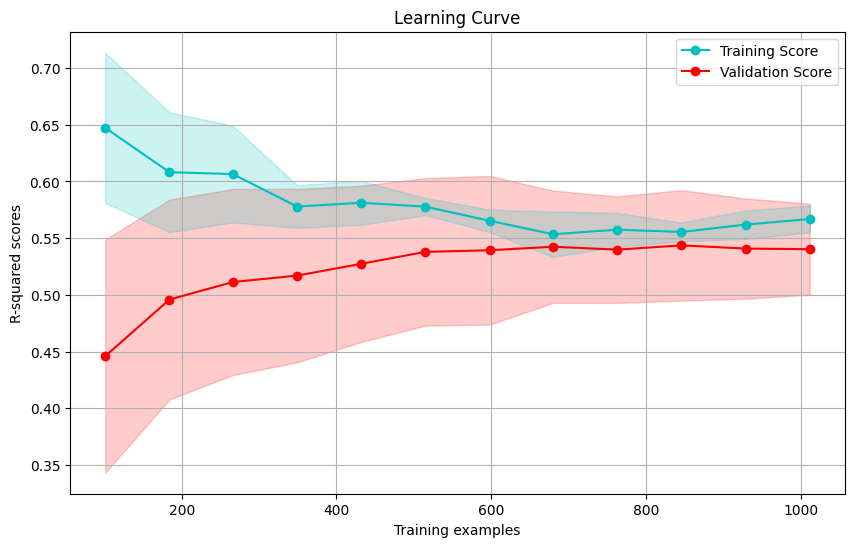

In [133]:
model1 = LinearRegression()

def plot_learning_curve(model, X=X_train, Y=Y_train):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, Y, train_sizes = np.linspace(0.1, 1.0, 12), cv=5, scoring= 'r2', shuffle=True, random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis =1)


    plt.figure(figsize=(10,6))

    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha = 0.2, color ='r')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color ='c')

    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'c', label = 'Training Score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color = 'r', label = 'Validation Score')

    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("R-squared scores")
    plt.legend(loc='best')
    plt.grid()
    plt.show()


plot_learning_curve(model1, X_train, Y_train)


Performance for both training and validtion seems to decreese and increase at same rate, So no overfitting

In [178]:
def print_errors(model,X_train = X_train ,X_test = X_test):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_pred)
    print(f'Mean Absolute Error: {mae}')
    mse = mean_squared_error(Y_test, Y_pred)
    print(f'Mean Squared Error: {mse}')
    r2 = r2_score(Y_test, Y_pred)
    print(f'R-squared: {r2}')

print_errors(model1)

Mean Absolute Error: 1.2651562547940902
Mean Squared Error: 3.961385138355689
R-squared: 0.4602235581562649


R^2 value is 46%, Which means that 46% of variance of the dependent variable can be explained by the independent variable which isnt alot.  

Let's try SVM for the same dataset

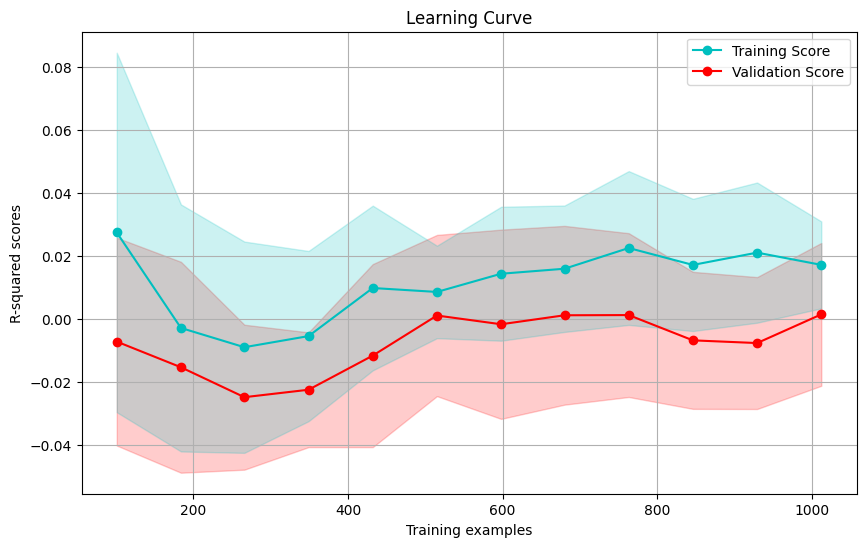

In [127]:
model2 = svm.SVR()

plot_learning_curve(model2, X_train, Y_train)

Graph clearly shows that SVM isnt a good fit for this dataset. 

In [152]:
print_errors(model2)

Mean Absolute Error: 1.6970196154168973
Mean Squared Error: 7.755024309964106
R-squared: -0.05669589859208424


Even the R^2 confirm that SVM is not a good fit for this dataset, Let's try Decision tree

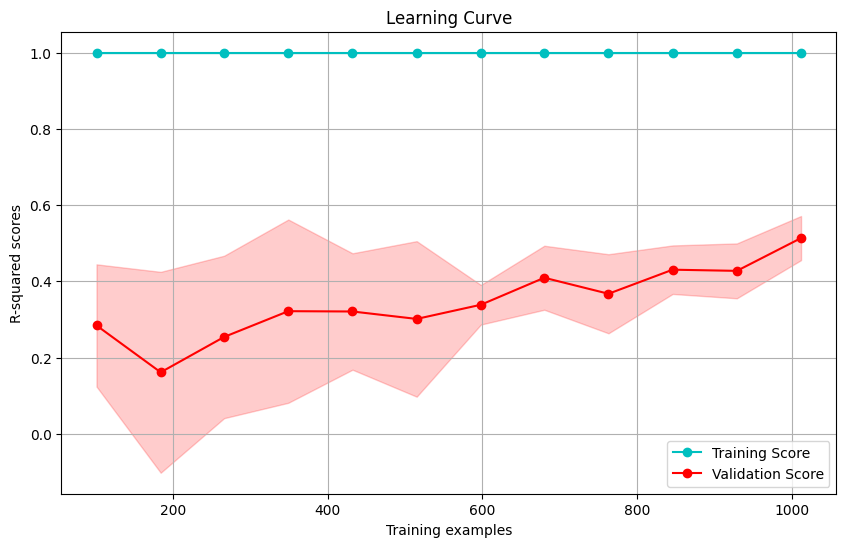

In [130]:
model3 = tree.DecisionTreeRegressor()

plot_learning_curve(model3, X_train, Y_train)

Decision tree clearly shows overfitting for the dataset.

In [131]:
model3.fit(X_train, Y_train)

model3.tree_.max_depth

23

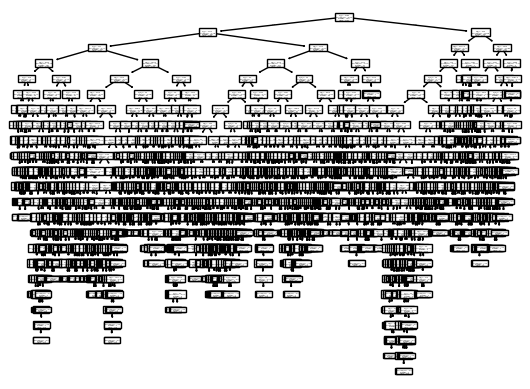

In [132]:
plot_tree(model3, filled=False)
plt.show()

The max depth of the tree is 23, which is alot and thus very less training sample for each node, lets prune tree at max dept as 4, and see if it improves the over fitting?

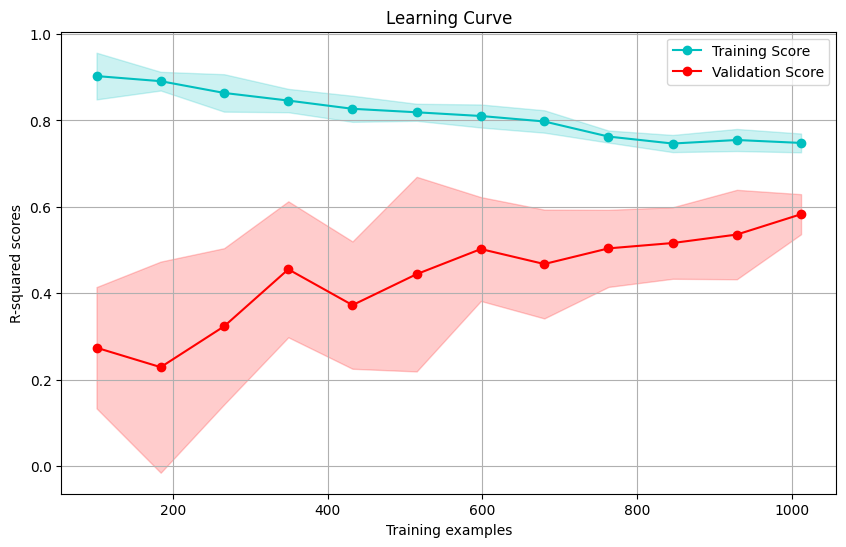

In [160]:
model4 = tree.DecisionTreeRegressor(max_depth=5)

plot_learning_curve(model4)

* The model improves as we prune depth of the trees as the training example increases, but still shows signs of overfitting
* Let's look at R^2 score for the test data, Does it show any improvement that leanear regression?

In [161]:
print_errors(model4)

Mean Absolute Error: 1.3097924585339868
Mean Squared Error: 4.380149570096821
R-squared: 0.4031629172336386


The R^2 is around 40%, Lets model a random Forest and see the if it improves the model genera

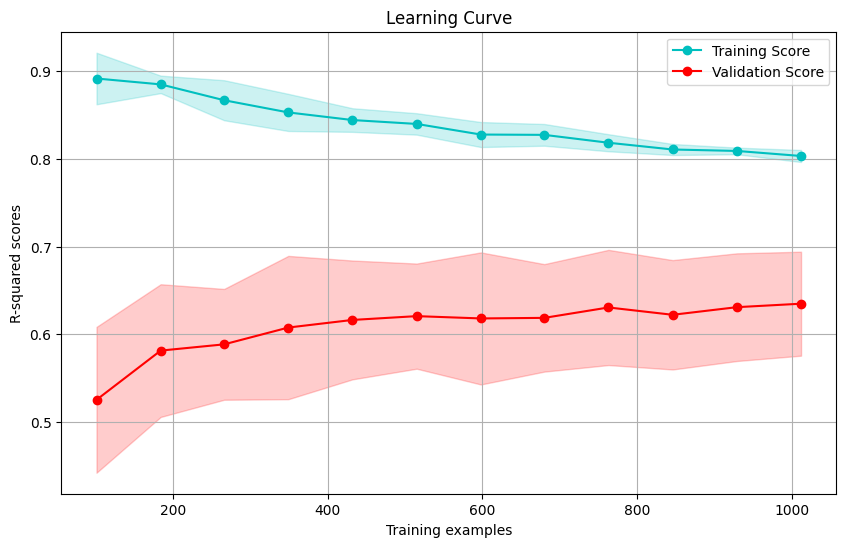

In [147]:
model5 = RandomForestRegressor(max_depth=5)

plot_learning_curve(model5)

Trends similar to decision trees are visible in random forest as well.
    But we can clearly say that the model improves as the valudation score which were around 50% hover around 65% now. 

In [162]:
print_errors(model5)

Mean Absolute Error: 1.1856864039678996
Mean Squared Error: 3.4156007902793952
R-squared: 0.5345918720488416


Also r^2 improves with value nearing 53% now, compared to 40% in case of decision tree. Let's model XGBoost

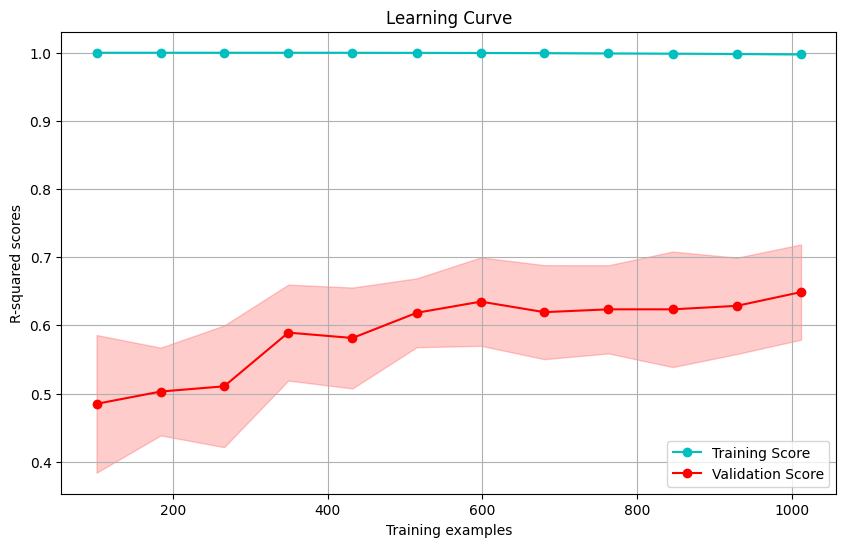

In [165]:
parameters = {
    "n_estimators": 500,
    "max_depth": 5,
    "loss": "squared_error",
}

model6 = ensemble.GradientBoostingRegressor(**parameters)
plot_learning_curve(model6)


Its overfitting as of now, lets decreese the n_estimators to 100 and max_depth to 4 and see how it behaves. 

In [166]:
print_errors(model6)

Mean Absolute Error: 1.1136383012549715
Mean Squared Error: 3.3888291037966045
R-squared: 0.5382397692280174


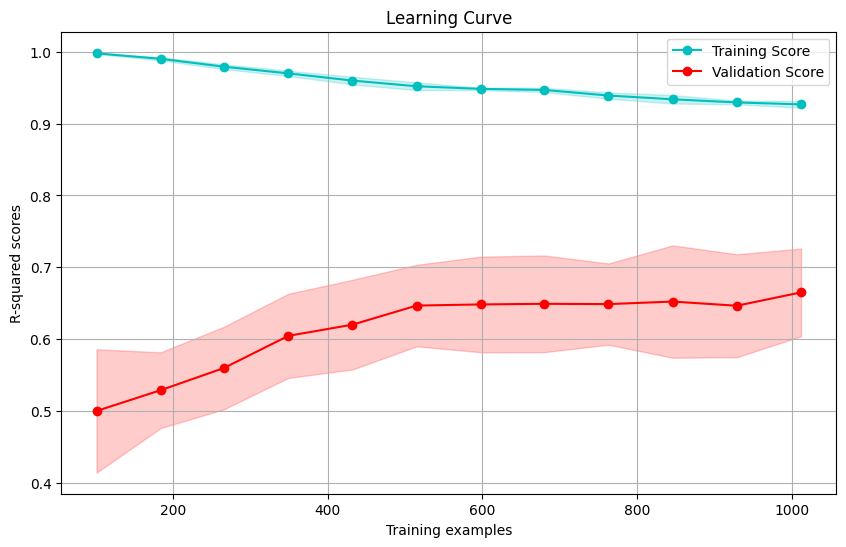

Mean Absolute Error: 1.1082001115722402
Mean Squared Error: 3.2316430048894014
R-squared: 0.5596578717886398


In [167]:
parameters = {
    "n_estimators": 100,
    "max_depth": 4,
    "loss": "squared_error",
}

model7 = ensemble.GradientBoostingRegressor(**parameters)
plot_learning_curve(model7)
print_errors(model7)

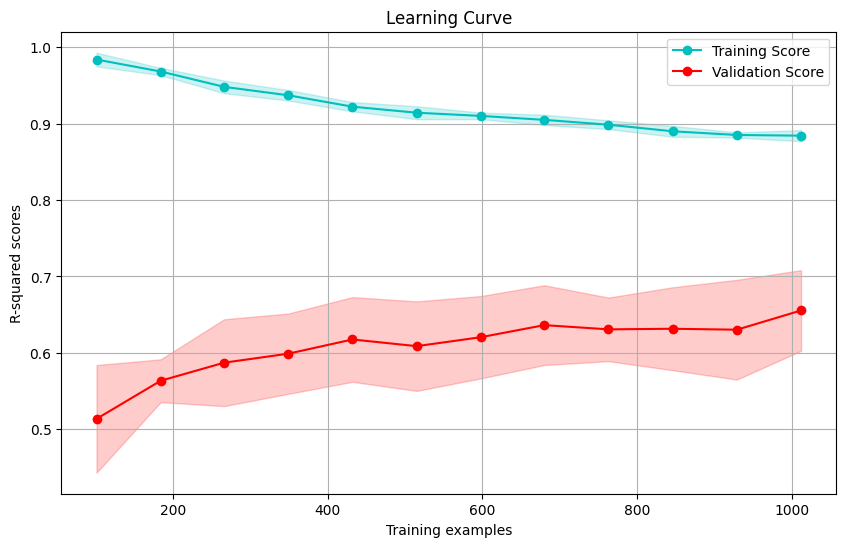

Mean Absolute Error: 1.102460168880593
Mean Squared Error: 3.1513776201545824
R-squared: 0.5705947946734878


In [175]:
parameters = {
    "n_estimators": 100,
    "max_depth": 3,
    "loss": "squared_error",
}

model8 = ensemble.GradientBoostingRegressor(**parameters)
plot_learning_curve(model8)
print_errors(model8)


After trying many differnt combination, model8 is the best model, Let's try adding/removing a few of the variable and see if the model improves more

In [234]:
X_train_filtered.columns

Index(['Municipality', 'Lift', 'Balcony', 'Living_area', 'Built_on_1900-1950',
       'Built_on_1951-2000', 'Built_on_2001-2010', 'Built_on_2011-present',
       'Built_on_Before 1900s', 'House_type_Fritidshus', 'House_type_Kedjehus',
       'House_type_Lägenhet', 'House_type_Parhus', 'House_type_Tomt',
       'House_type_Villa'],
      dtype='object')

In [227]:
X_train_filtered = X_train.drop(columns=['Floor', 'Operating_cost', 'Other_area', 'Rooms', 'Plot_area'])
X_test_filtered = X_test.drop(columns=['Floor', 'Operating_cost', 'Other_area', 'Rooms', 'Plot_area'])

parameters = {
    "n_estimators": 100,
    "max_depth": 3,
    "loss": "squared_error",
}

model8 = ensemble.GradientBoostingRegressor(**parameters)
# plot_learning_curve(model8, X_train_filtered)

model8.fit(X_train_filtered, Y_train)
y_pred = model8.predict(X_test_filtered)


mae = mean_absolute_error(Y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(Y_test, y_pred)
print(f'Mean Squared Error: {mse}')


r2 = r2_score(Y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.0756938691179339
Mean Squared Error: 2.8263914589818455
R-squared: 0.6148772533589084


Muncipality: 26%(reduces)
Living_area: 50%(reduces)
Floor : 57% (doesn't affect)
Operating_cost : 60%(Improves)
Other_area: 58% (slightly improves)
Rooms: 58% (slightly improves)
Built_on: 55%(reduces)
Plot_area: 59(Improves)

"Living_area" and "Muncipality" drastically reduces the performance of the model. Which support our insight during the EDA phase as well. Whereas removing some other vairables such as "Floor", 'Operating_cost', 'Other_area', 'Rooms', 'Plot_area' improves the performance, Thus for the final model  these variables are removed.

Attributes in final models are 'Municipality', 'House_type', 'Lift', 'Balcony', 'Living_area', 'Built_on', and the target variable 'Final_Price'. 

The R^2 error of the model is around 61%, which indicates that only these variables are not enough for predicting the final price of the property. other variables such as population, crowd, accesibility, publick transfort, parking, natural hazad prone area, taxes, how many times the property has been sold before also playes an important part in final price of the property. As we do not have these information. It is hard to predict the exact final price of property, which is even showed by our model.

Let move on to next stage of the project, which is deploying the model to a webapplication on AWS.


In [232]:
with open('encoding_dict.pkl', "wb") as f:
    pickle.dump(encode_dict, f)

In [233]:
pickle.dump(model8, open("FinalModel.pkl", "wb"))